# Исследование объявлений о продаже квартир
**Цель проекта:**

Определить рыночную стоимость объектов недвижимости. Построить автоматизированную систему для отслеживания аномалий и мошеннической деятельности. 

**Исходные данные:**

Данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах (файл - real_estate_data.csv).

О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. К первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка.

## Шаг 1. Знакомство с данными и предобработка

In [1]:
import pandas as pd
data = pd.read_csv('real_estate_data.csv', sep='\t')
print(data.head())


   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

В таблице 22 столбца с различными характеристиками квартир, посмотрим, какие данные в них содержатся.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Тип большинства столбцов - float, что логично, учитывая, что в них содержатся числа и не обязательно целые. Взглянем на распределение данных по столбцам с помощью гистограм

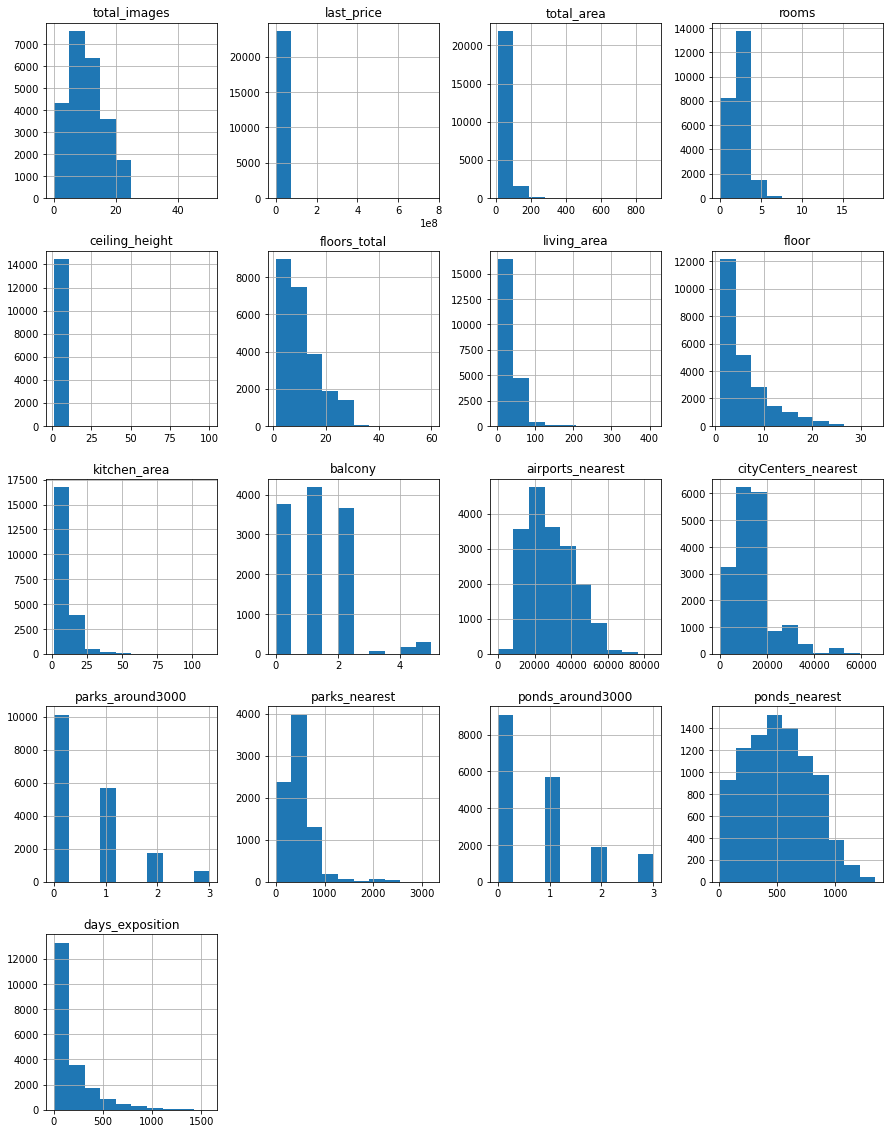

In [3]:
data.hist(figsize=(15, 20));

В некоторых столбцах видны резко выбивающиеся данные. Ярче всего это видно в стоблбцах с площадью, ценой и высотой потолка. Вернемся к этим данным позже и разберемся в природе аномалий.

### Предобработка данных

Посмотрим на количество пропущеной информации в таблице

In [4]:
data.isna().sum()
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Пропуски в столбцах - число балконов,  число парков и водоемов в радиусе 3 км скорее всего означает, что таковых нет, заменим пропуски на нулевые значения. 
    
В столбце апартаменты (булев тип) пропусков больше всего, скорее всего потому что в этом случае квартира апартаментами не является, заменим пропущеные значения на False.
    
В остальных столбцах скорее всего данные просто не были указаны при выставлениии объявления. Оставим их без изменений. Но заметим, что две трети не указали расстояние до ближайшего парка и пруда.

In [5]:
data['balcony']=data['balcony'].fillna(0)
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['is_apartment']=data['is_apartment'].fillna(False)

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
import warnings
warnings.filterwarnings('ignore')

for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna())&(data['locality_name'] == locality_name), 'ceiling_height'] = median
    
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()    

In [7]:
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    data.loc[(data['cityCenters_nearest'].isna())&(data['locality_name'] == locality_name), 'cityCenters_nearest'] = median
    

Тип данных в столбце с датой публикации изменим на datetime, чтобы в дальнейшем можно было вести расчеты по ним.

In [8]:
#data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

data['first_day_exposition'] = data['first_day_exposition'].astype('datetime64[M]')
data['floor'] = data['floor'].astype('float')


Проверим наличие дупликатов в таблице в целом и в столбце с наименованиями населенных пунктов

In [9]:
print(data.duplicated().sum())

0


In [10]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Некоторые названия поселков повротяются с разными описаниями, приведем их к одному виду - поселок.

In [11]:
locality_type = ['городского типа', 'городской посёлок', 'поселок', 'посёлок', 'коттеджный ']

data['locality_name'] = data['locality_name'].replace(locality_type, 'поселок', regex=True)


Теперь при группировке данных не будет задвоения 

Обратимся к аномальным значениям в стоблбцах с площадью, ценой и высотой потолка. Удалим единственную строку с высотой 100 метров, а те, которые выше 24 разделим на 10, т.к. наверняка произошла ошибка при вводе данных.

1.9578885185028903


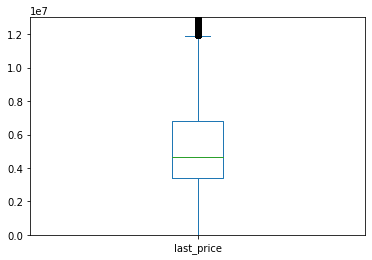

In [12]:
import matplotlib.pyplot as plt
data['last_price'].plot(kind='box')
plt.ylim(0, 13000000)
print((data.query('last_price>25000000')['last_price'].count()/data['last_price'].count())*100)

0.03267821296858223


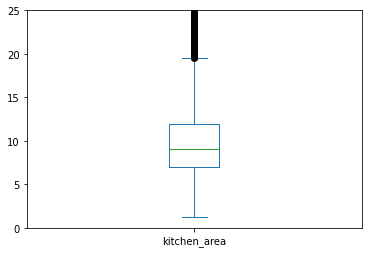

In [13]:
data['kitchen_area'].plot(kind='box')
plt.ylim(0, 25)
print((data.query('kitchen_area>80')['kitchen_area'].count())/(data['kitchen_area'].count())*100)

0.009175995595522114


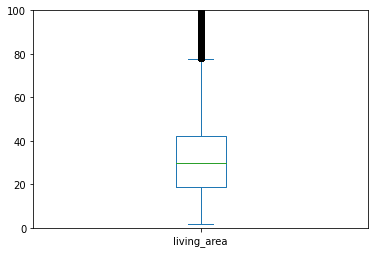

In [14]:
data['living_area'].plot(kind='box')
plt.ylim(0, 100)
print((data.query('living_area>350')['living_area'].count())/(data['living_area'].count())*100)

0.25739482678594033


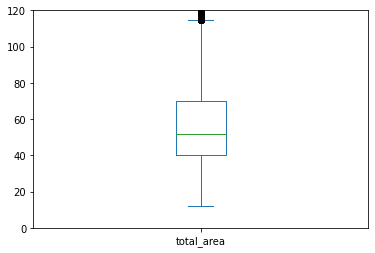

In [15]:
data['total_area'].plot(kind='box')
plt.ylim(0, 120)
print((data.query('total_area>300')['total_area'].count()/data['total_area'].count())*100)

0.1687834929743871


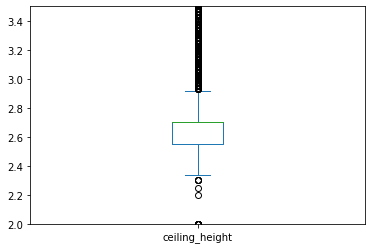

In [16]:
data['ceiling_height'].plot(kind='box')
plt.ylim(2, 3.5)
print((data.query('ceiling_height>5')['ceiling_height'].count()/data['ceiling_height'].count())*100)

Строки с ценой выше 25 миллионов составляют чуть больше 2%, с общей площадью выше 300м и высотой потолков выше 5м - меньше процента, отбросим их, чтобы они не искажали дальнейшие расчеты.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  float64       
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [18]:
data = data.query('last_price<30000000')
data = data.query('total_area<300')
data = data.query('kitchen_area<80')

In [19]:
def ceiling_check(row):

            if row['ceiling_height'] >= 20.0:
                return row['ceiling_height']/10
            else:
                return row['ceiling_height']
    
data['ceiling_height'] = data.apply(ceiling_check, axis=1)


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21119 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21119 non-null  int64         
 1   last_price            21119 non-null  float64       
 2   total_area            21119 non-null  float64       
 3   first_day_exposition  21119 non-null  datetime64[ns]
 4   rooms                 21119 non-null  int64         
 5   ceiling_height        21119 non-null  float64       
 6   floors_total          21081 non-null  float64       
 7   living_area           20691 non-null  float64       
 8   floor                 21119 non-null  float64       
 9   is_apartment          21119 non-null  bool          
 10  studio                21119 non-null  bool          
 11  open_plan             21119 non-null  bool          
 12  kitchen_area          21119 non-null  float64       
 13  balcony         

В процессе предобработки данных были найдены и заполнены пропущеные значения высоты потолков и расстояния до центра города медианными значениями, названия поселков приведены к общему виду.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим дополнительные показатели в таблицу для дальнейшего исследования влияния различных факторов нв цену квартиры.

In [21]:
data['one_sq_meter_price'] = (data['last_price']/data['total_area']).round(2)

In [22]:
import numpy as np
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

In [23]:
def floor_typing(row):

        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'

data['floor_type'] = data.apply(floor_typing, axis=1)


In [24]:
data['km_to_centre'] = (data['cityCenters_nearest']/1000).round(0)

### Проведите исследовательский анализ данных

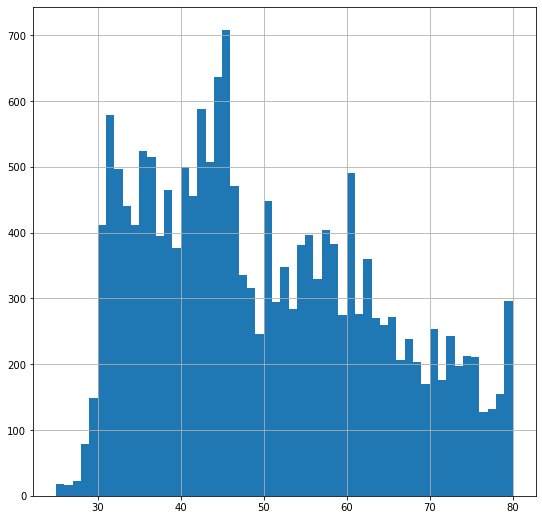

In [25]:
data['total_area'].hist(figsize=(9, 9), bins=55, range=(25,80));

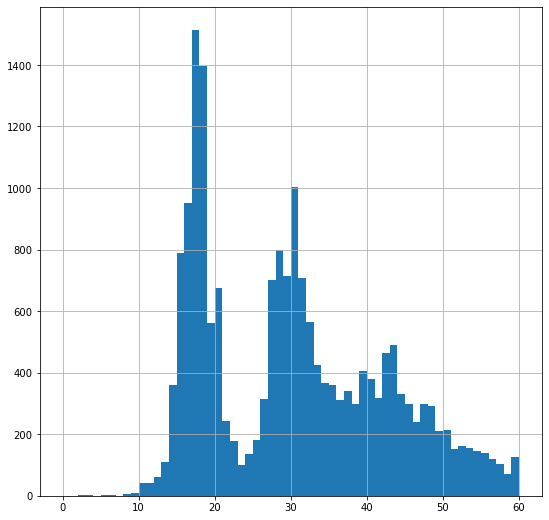

In [26]:
data['living_area'].hist(figsize=(9, 9), bins=60, range=(0,60));

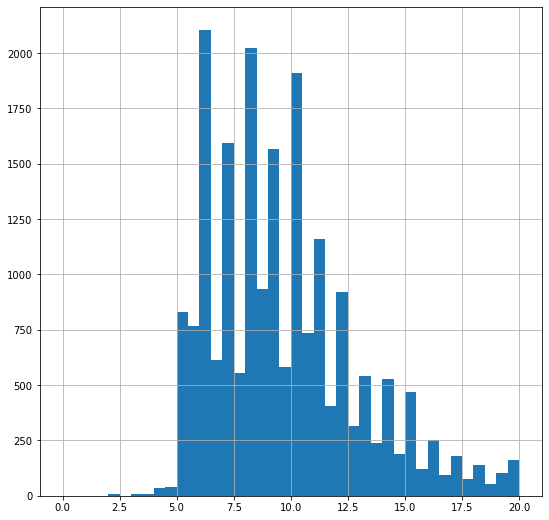

In [27]:
data['kitchen_area'].hist(figsize=(9, 9), bins=40, range=(0,20));

Графики площадей квартир похожи на распределение Пуассона с пиками около 33м2, 45 м2 и 60м2 по общей площади (что соответствует самым частым 1-, 2- и 3-х комнатным квартирам), 6-10 м2 по площади кухни - это хороший знак, т.к. похоже на правду. Интересен провал в жилой площади около 24м2, а два пика около 17м2 и 30м2 объяснимы пиками в графике с общей площадью. 

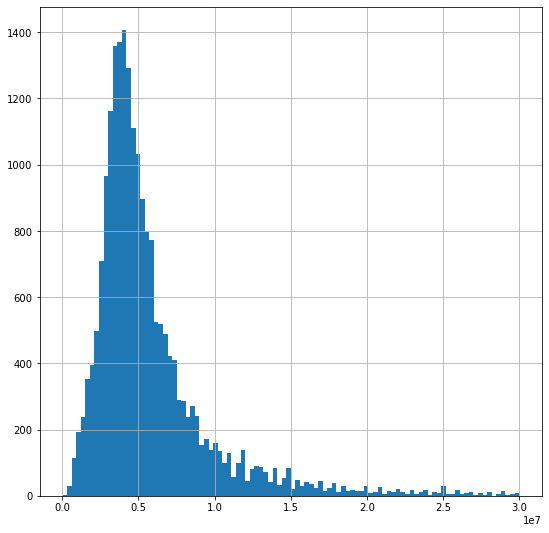

In [28]:
data['last_price'].hist(figsize=(9, 9), bins=100);


Цены квартир очень правильно и красиво распределены по графику без дополнительных пиков и провалов.

<AxesSubplot:>

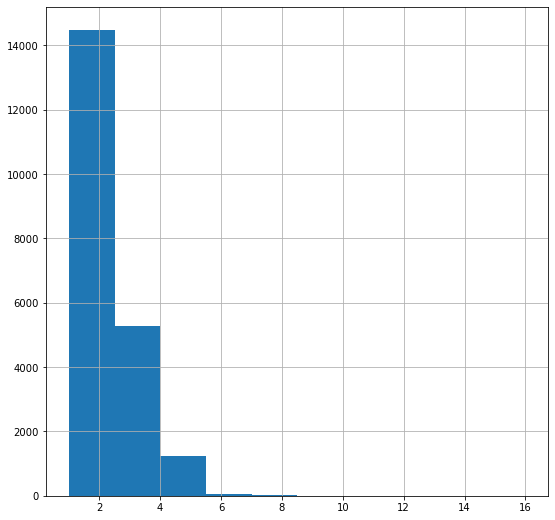

In [29]:
data['rooms'].hist(figsize=(9, 9), bins=10)


Большинство квартир с 1, 2 и 3 комнатами и чем больше комнат, тем реже объявления с ними.

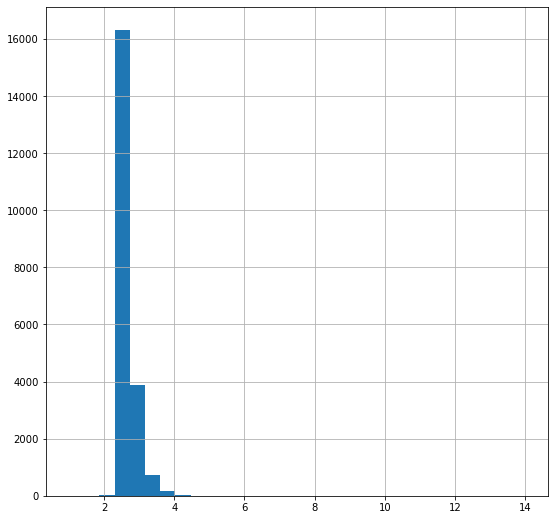

In [30]:
data['ceiling_height'].hist(figsize=(9, 9), bins=30);


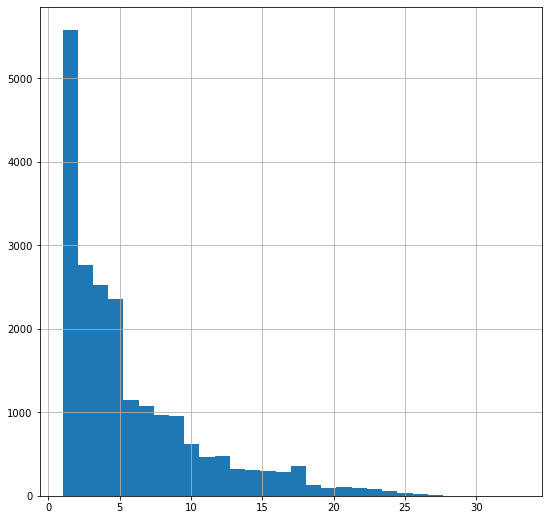

In [31]:
data['floor'].hist(figsize=(9, 9), bins=30);

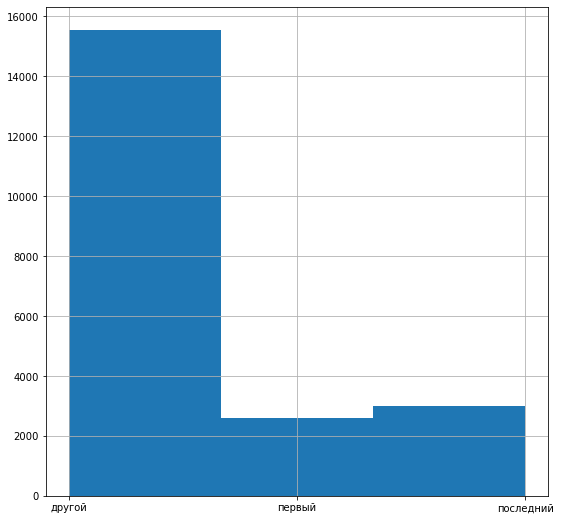

In [32]:
data['floor_type'].hist(figsize=(9, 9), bins=3);

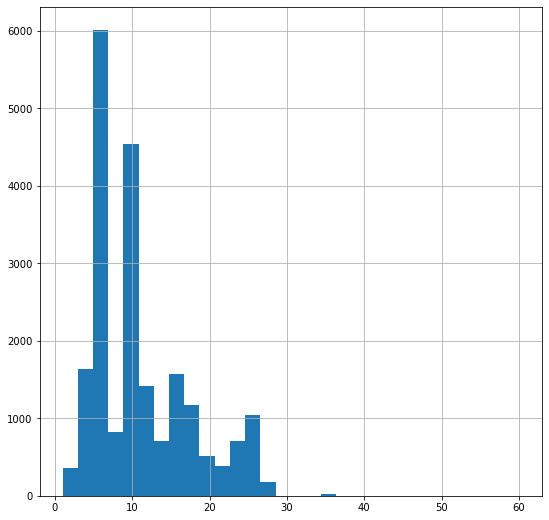

In [33]:
data['floors_total'].hist(figsize=(9, 9), bins=30);

Из трех графиков выше видно, что больше квартир продаются в 5ти- и 10тиэтажках и чаще всего они находятся не на первом и не на последних этажах, что было ожидаемо. Так же как и то, что квартир на первом и последнем этажах примерно одинаковое количество.

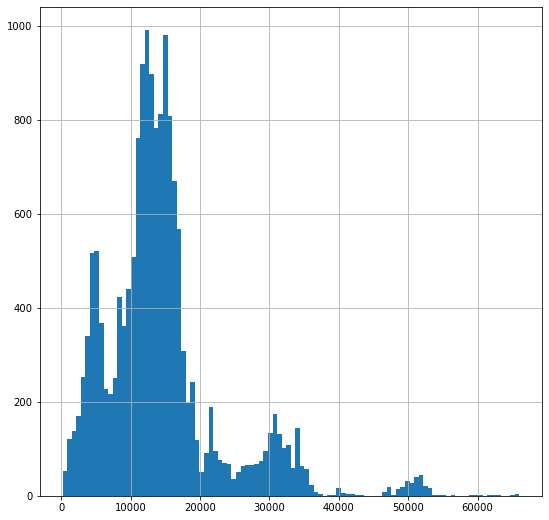

In [34]:
data['cityCenters_nearest'].hist(figsize=(9, 9), bins=100);


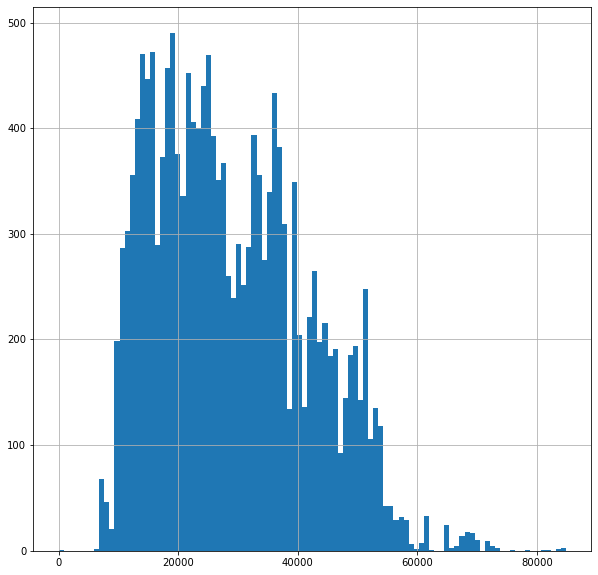

In [35]:
data['airports_nearest'].hist(figsize=(10, 10), bins=100);


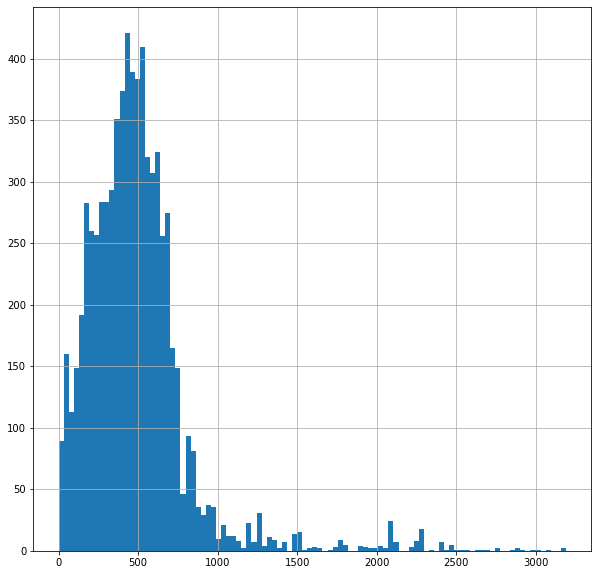

In [36]:
data['parks_nearest'].hist(figsize=(10, 10), bins=100);


Из графиков по расстояниям видно, что большинсство квартир находятся вблизи парка - в радиусе до километра, однако, мы помним, что в 2/3 объявлений расстояние до парка не указано. 

Графики по расстояниям до аэропорта и центра города неровные и имеют несколько пиков, что можно объяснить неравномерной застройком местности, ведь данные объявления не только из Санкт-Петербурга, но и из ближайших поселений.

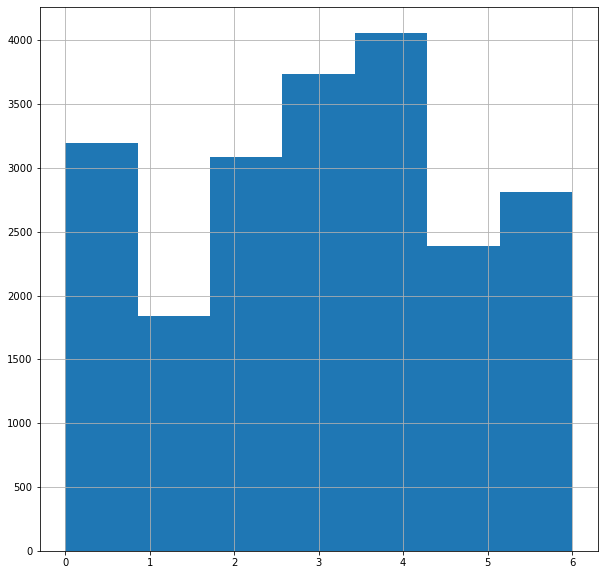

In [37]:
data['exposition_weekday'].hist(figsize=(10, 10), bins=7);


Выше видим, что объявления чаще выкладывают в будние дни, предполагаю, что это связано с тем, что их выкладывают агенты в рабочее время, а не собственники квартир.


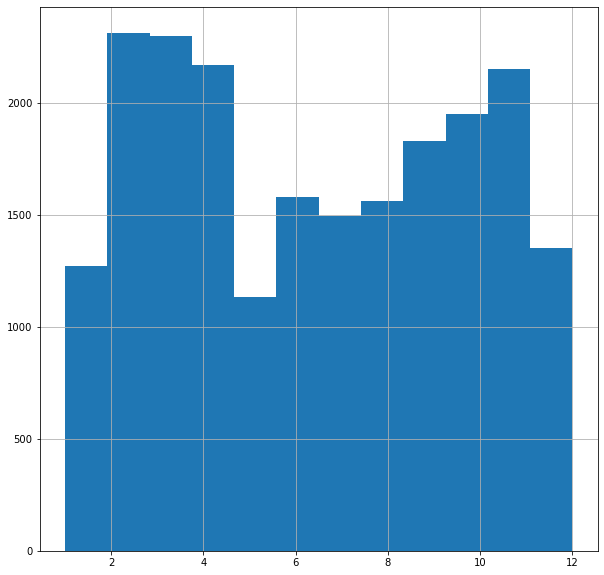

In [38]:
data['exposition_month'].hist(figsize=(10, 10), bins=12);


Провалы в январе и мае могу объяснить малым количеством рабочих дней, а в декабре могу предположить, что люди не начинают продажу квартиры в конце года.


#### Посмотрим на скорость продажи квартир

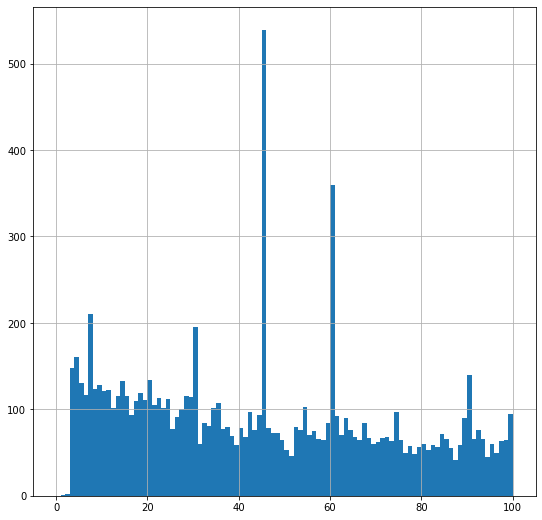

In [39]:
data['days_exposition'].hist(figsize=(9,9), bins=100,  range=[0,100]);

<AxesSubplot:>

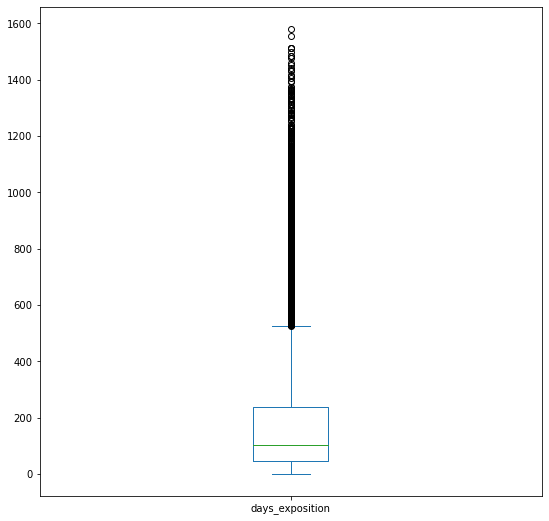

In [40]:
data['days_exposition'].plot(figsize=(9,9), kind='box')

In [41]:
data['days_exposition'].describe()

count    18217.000000
mean       184.246638
std        221.075758
min          1.000000
25%         45.000000
50%        101.000000
75%        237.000000
max       1580.000000
Name: days_exposition, dtype: float64

По обоим графикам видно, что скорость продажи более 600 дней можно считать долгой, также мы знаем, что 75% квартир продаются в течение первых 247 дней. 

Самое быстрое снятие с объявления - 1 день, маловероятно, что квартира продалась за один день, но и исключать такую возможность нельзя. Самое долгое объявление - 1580 дней, это больше, чем 4 года. Либо продавец запросил слишком высокую цену (а может и само объявление было неудачным) и не мог так долго продать квартиру, либо забыл снять объявление после продажи. 

А чаще всего квартиры продаются в срок 45 или 60 дней, а, точнее объявление остается активным в течение этого времени. Возможно, на сайте объявления удаляются автоматически, если не продлить их срок.

### Изучим влияние различных факторов на общую стоимость квартиры

0.7934726809762024


<AxesSubplot:xlabel='last_price', ylabel='total_area'>

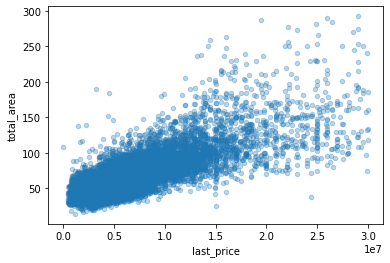

In [42]:
print(data['last_price'].corr(data['total_area']))
data.plot(kind='scatter', x='last_price', y='total_area', alpha=0.3)

0.6859967639016282


<AxesSubplot:xlabel='last_price', ylabel='living_area'>

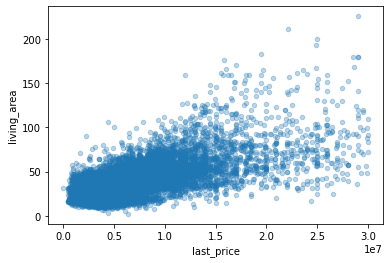

In [43]:
print(data['last_price'].corr(data['living_area']))
data.plot(kind='scatter', x='last_price', y='living_area', alpha=0.3)

0.6066295998069386


<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

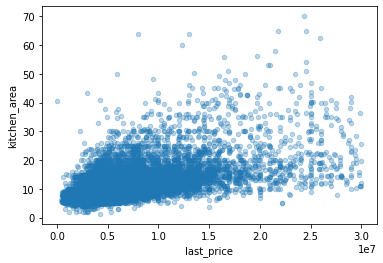

In [44]:
print(data['last_price'].corr(data['kitchen_area']))
data.plot(kind='scatter', x='last_price', y='kitchen_area', alpha=0.3)

Корреляция площади и цены очень высокая - 0.79, но и корреляция между ценой и жилой площадью и размером кухни тоже достаточно высокая - 0.68 и 0.59 соответственно. 


<AxesSubplot:title={'center':'зависимость цены от типа этажа'}, xlabel='floor_type'>

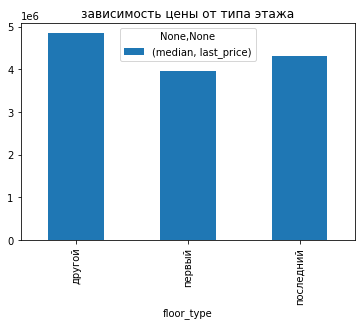

In [45]:
floor_pivot = data.pivot_table(
    index='floor_type', values='last_price', aggfunc=['median']
)
floor_pivot.plot(kind='bar', title='зависимость цены от типа этажа')


In [46]:
print(floor_pivot)

               median
           last_price
floor_type           
другой      4850000.0
первый      3950000.0
последний   4300000.0


Квартиры на первом этаже стоят в среднем на 20% дешевле тех, что не на крайних этажах, а те, что на последнем на 10%.

<AxesSubplot:title={'center':'зависимость цены от количества комнат'}, xlabel='rooms'>

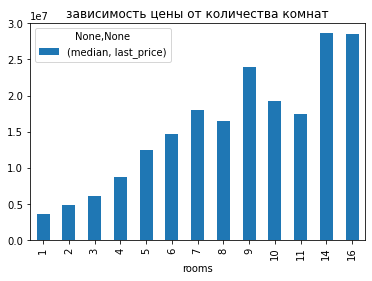

In [47]:
room_pivot = data.pivot_table(
    index='rooms', 
    values='last_price', 
    aggfunc=['median']
)
room_pivot.plot(kind='bar', title='зависимость цены от количества комнат')


Предсказуемо видим, что с есть прямая зависимость цены от количества комнат.

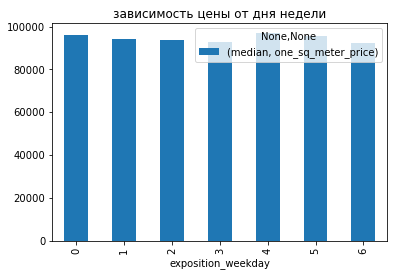

In [48]:
weekday_pivot = data.pivot_table(
    index='exposition_weekday', values='one_sq_meter_price', aggfunc=['median']
)
weekday_pivot.plot(kind='bar', title='зависимость цены от дня недели');


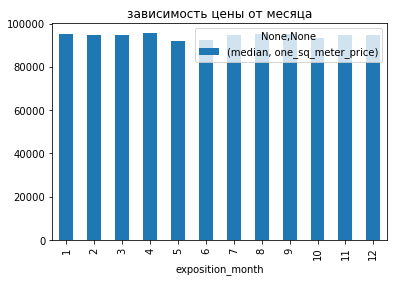

In [49]:
month_pivot = data.pivot_table(
    index='exposition_month', values='one_sq_meter_price', aggfunc=['median']
)
month_pivot.plot(kind='bar', title='зависимость цены от месяца');

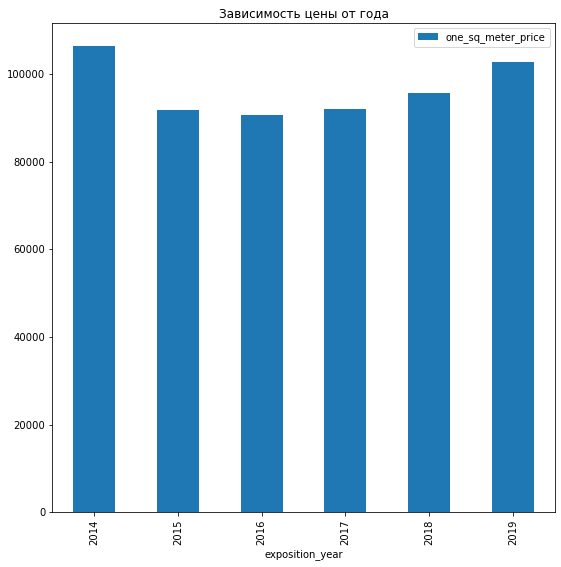

In [50]:
year_pivot = data.pivot_table(
    index='exposition_year', 
    values=['one_sq_meter_price'], aggfunc=['median', 'count']
)
year_pivot['median'].plot(kind='bar', figsize=(9,9), title='Зависимость цены от года');

In [51]:
print(year_pivot['count'])
print(year_pivot)

                 one_sq_meter_price
exposition_year                    
2014                            122
2015                           1055
2016                           2523
2017                           7374
2018                           7410
2019                           2635
                            median              count
                one_sq_meter_price one_sq_meter_price
exposition_year                                      
2014                    106265.855                122
2015                     91842.110               1055
2016                     90681.820               2523
2017                     92109.180               7374
2018                     95752.065               7410
2019                    102605.860               2635


Цена не сильно зависит от дня или месяца, в котором было выложено объявление. Цена за кв. метр с каждым годом стабильно растет. В 2104 году цена значительно выше, однако мы видим, что объявлений за 2014 у нас значительно меньше, а значит, мы можем сделать вывод, что с каждым годом цена за кв. метр растет.

In [52]:
print(data.corr()['last_price'])

total_images           0.153854
last_price             1.000000
total_area             0.793473
rooms                  0.519763
ceiling_height         0.345905
floors_total           0.085305
living_area            0.685997
floor                  0.087311
is_apartment           0.007623
studio                      NaN
open_plan                   NaN
kitchen_area           0.606630
balcony                0.035711
airports_nearest      -0.035904
cityCenters_nearest   -0.349777
parks_around3000       0.281342
parks_nearest          0.033656
ponds_around3000       0.295410
ponds_nearest         -0.108695
days_exposition        0.126875
one_sq_meter_price     0.663199
exposition_weekday    -0.000578
exposition_month       0.001862
exposition_year       -0.039451
km_to_centre          -0.350692
Name: last_price, dtype: float64


In [53]:
pivot_corr = data.pivot_table(index='locality_name',
    values=['one_sq_meter_price'],
    aggfunc=['count', 'median']
            )
pivot_corr.columns=['количество объявлений', 'медианная цена за метр']
pivot_corr = pivot_corr.sort_values('количество объявлений', ascending=False).head(10)

print(pivot_corr)

                   количество объявлений  медианная цена за метр
locality_name                                                   
Санкт-Петербург                    14044               103891.25
поселок Мурино                       450                84262.42
поселок Шушары                       398                77223.32
Всеволожск                           357                65789.47
Пушкин                               336               100000.00
Колпино                              321                74722.22
Гатчина                              294                67860.57
поселок Парголово                    289                92261.90
деревня Кудрово                      231                91428.57
Выборг                               201                58407.08


Среди населенных пунктов с наибольшим количеством объявлений самая высокая цена, ожидаемо, в Санкт-Петербурге - 103 тысячи за кв. метр, а самая низкая в Выборге - 58,4 тысяч рублей, это на 44% меньше

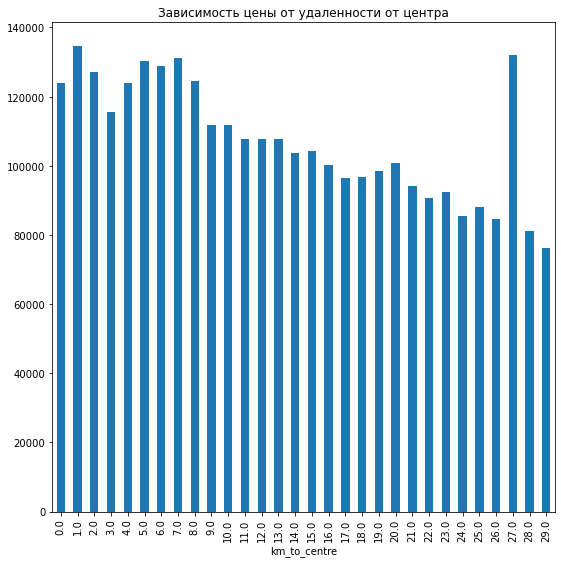

In [54]:
st_peters_data = data.query('locality_name=="Санкт-Петербург"')
st_peters_pivot = st_peters_data.pivot_table(
    index='km_to_centre', 
    values=['one_sq_meter_price'],
    aggfunc=['mean', 'count']
)
st_peters_pivot.columns=['средняя цена', "количество объявлений"]
st_peters_pivot['средняя цена'].plot(kind='bar', figsize=(9,9), title = 'Зависимость цены от удаленности от центра')
plt.show()

Мы можем наблюдать, что с удалением от центра Санкт-Петербурга цена квартиры падает, а после 26 км есть всплеск цены, взглянем на объем данных по этой отметке.

In [55]:
print(st_peters_pivot)

               средняя цена  количество объявлений
km_to_centre                                      
0.0           123871.662857                     14
1.0           134767.155197                    152
2.0           127242.266892                    251
3.0           115545.853642                    313
4.0           123836.702843                    598
5.0           130344.250265                    791
6.0           128966.574990                    479
7.0           131279.961386                    332
8.0           124658.305903                    537
9.0           111660.270019                    536
10.0          111873.133399                    662
11.0          107623.523010                   1093
12.0          107804.183298                   1513
13.0          107658.817846                   1337
14.0          103736.031648                   1183
15.0          104162.497442                   1431
16.0          100258.796149                   1153
17.0           96327.713489    

После 24 км объявлений крайне мало, а следовательно, я не буду делать выводы основываясь на них.

### Общий вывод

Передо мной стояла задача определить факторы, наиболее сильно влияющие на цену квартир в Санкт-Петербурге. 

Для этого у меня былы данные о 23699 объявлений с 2014 по 2019 гг В Санкт-Петербурге и Ленинградской области. 

В ходе предобработки данных были обнаружены пропущенные данные в столбцах с количеством балконов и количеством парков и прудов в радиусе 3 км, предполагая отсутсвие таковых, пустые значения я заменила нулями. Для некоторых населенных пунктов в объявлениях были указаны разные написания и были приведены к общему виду, что позже позволило мне группировать данных по населенным пунктам. Также я избавилась от некоторых объявлений (в сумме не больше 2%), т.к. их показатели резко выбивались из общего массива данных.

Я добавила некоторые показатели в таблицу - цена одного квадратного метра, день недели, месяц и год публикации объявления месяц публикации объявления,мтип этажа квартиры (значения — «первый», «последний», «другой») и расстояние в км до центра города.

Изучая непосредственно влияние различных факторов на цену квартиры, я выяснила, что больше всего на цену влияет площадь квартиры и количество комнат, а также удаленность от центра Санкт-Петербурга. Так, медианная цена в Выборге составляет только 57% от медианной цены в Санкт-Петербурге.

Чуть менее заметно, но очень стабильно на цену влияет этаж квартиры. Квартиры на первом этаже стоят в среднем на 20% дешевле тех, что не на крайних этажах, а те, что на последнем на 10%.

Вдобавок я выяснила, что с каждым годом цена на недвижимость стабильно растет.